### Authentication and enabling GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tensorflow is already installed in Colab
# check if tensorflow is installed
import tensorflow as tf
print(tf.__version__) 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('you must enable GPU! Go to:')
  print('\nRuntime')
  print('\tChange runtime type')
  print('\t\tHardware Accelerator: GPU')

  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.7.0
Found GPU at: /device:GPU:0


## Library and Utility

In [ ]:
import os
import os.path
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.python.framework import ops
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

#magic command for enabling tensorflow 1.x
#%tensorflow_version 1.x 

# print tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)





2.7.0
2.7.0


In [ ]:
def conversion_batch_to_narray(dataset):
  lista = np.array([])
  labels_set = np.array([])
  i=0
  for elem,elem2 in dataset.as_numpy_iterator():
    print(elem.shape)
    if(i==0):
      lista = elem
    else:
      lista =  np.append(lista,elem,axis=0)
    i=i+1
    labels_set = np.append(labels_set,elem2,axis=0)
    print(lista.shape)
    print(i)
    if(i==-1):
      break
  return lista, labels_set


In [ ]:
#Majority prediction function
def majority_prediction_classify(test_images,predictions,NUMBER_CLASSES):
  #predictions must be int representing specific classes
  # model1 : [1,0,3,0]
  # model2 : [1,0,2,0]
  # model3 : [1,1,2,0]
  # result : [1,0,2,0]

  #test_images is a pandas Dataframe
  general_prediction = []

  #Creo counter a 33 classi
  counter = np.zeros(NUMBER_CLASSES, dtype=int)

  for j in range(len(test_images)):
    for pre in predictions:
      index = pre[j]
      counter[index] = counter[index] + 1
      #print(counter)
    
    #Trovo l'indice associato alla classe più scelta
    max_index_col = np.argmax(counter)
    #Aggiungo classe scelta dalla maggioranza
    general_prediction.append(max_index_col)

    #Resetto il counter
    counter = np.zeros(NUMBER_CLASSES, dtype=int)

  #print(general_prediction)
  return general_prediction

#Weighted prediction function
def weighted_prediction_classify(test_images,predictions,weights,NUMBER_CLASSES):
  #predictions must be probability distributions
  # model1 : [[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4]]
  # model2 : [[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4]]
  # model3 : [[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4],[0.1,0.3,0.2,0.4]]
  #                  ^_ obj1             ^__obj2           ^__obj3          ^__obj4
  #weights = [0.98,0.88,0.93]
  # make predictions
  yhats = np.array(predictions)
  # weighted sum across ensemble members
  summed = np.tensordot(yhats, weights, axes=((0),(0)))
  # argmax across classes
  result = np.argmax(summed, axis=1)
  #print(result)

  return result
  # result : [1,0,2,0]




def print_confusion_matrix(y_true,y_pred,name_classes):

  cf_matrix = confusion_matrix(y_true, y_pred, normalize=None)
  plt.figure(figsize = (15,10))
  sns.heatmap(cf_matrix, 
              annot=True, 
              xticklabels = name_classes, 
              yticklabels = name_classes,fmt="d"
              )
  plt.title('Confusion Matrix')
  plt.show()

### Loading datasets

In [ ]:
HEIGHT_PRETRAINED = 224 
WIDTH_PRETRAINED = 224 
HEIGHT_SCRATCH = 180 
WIDTH_SCRATCH = 180 
BATCH_SIZE = 32

PATH_HOME = '/content/drive/Shareddrives/CIDL/'
PATH_DATASET_MULTILABEL = '/content/drive/Shareddrives/CIDL/dataset/preprocessed'
PATH_DATASET_BINARY = '/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary'




In [ ]:
test_pretrained_multilabel =image_dataset_from_directory(
    PATH_DATASET_MULTILABEL,
    validation_split=0.1,
    subset= "validation",
    image_size=(HEIGHT_PRETRAINED, WIDTH_PRETRAINED),
    seed = 123,
    batch_size=BATCH_SIZE)

test_scratch_multilabel =image_dataset_from_directory(
    PATH_DATASET_MULTILABEL,
    validation_split=0.1,
    subset= "validation",
    image_size=(HEIGHT_SCRATCH, WIDTH_SCRATCH),
    seed = 123,
    batch_size=BATCH_SIZE)

test_pretrained_binary =image_dataset_from_directory(
    PATH_DATASET_BINARY,
    validation_split=0.1,
    subset= "validation",
    image_size=(HEIGHT_PRETRAINED, WIDTH_PRETRAINED),
    seed = 123,
    batch_size=BATCH_SIZE)

test_scratch_binary =image_dataset_from_directory(
    PATH_DATASET_BINARY,
    validation_split=0.1,
    subset= "validation",
    image_size=(HEIGHT_SCRATCH, WIDTH_SCRATCH),
    seed = 123,
    batch_size=BATCH_SIZE)



from tensorflow.keras.layers.experimental.preprocessing import Rescaling
rescale = Rescaling(scale=1.0/255)
test_scratch_multilabel = test_scratch_multilabel.map(lambda image,label:(rescale(image),label))
   = test_scratch_binary.map(lambda image,label:(rescale(image),label))

Found 2652 files belonging to 33 classes.
Using 265 files for validation.
Found 2652 files belonging to 33 classes.
Using 265 files for validation.
Found 3469 files belonging to 2 classes.
Using 346 files for validation.
Found 3469 files belonging to 2 classes.
Using 346 files for validation.


In [ ]:
#X_test_pre_mul, y_test_pre_mul = conversion_batch_to_narray(test_pretrained_multilabel)
X_test_scr_mul, y_test_scr_mul = conversion_batch_to_narray(test_scratch_multilabel)
#X_test_pre_bin, y_test_pre_bin = conversion_batch_to_narray(test_pretrained_binary)
#X_test_scr_bin, y_test_scr_bin = conversion_batch_to_narray(test_scratch_binary)

(32, 180, 180, 3)
(32, 180, 180, 3)
1
(32, 180, 180, 3)
(64, 180, 180, 3)
2
(32, 180, 180, 3)
(96, 180, 180, 3)
3
(32, 180, 180, 3)
(128, 180, 180, 3)
4
(32, 180, 180, 3)
(160, 180, 180, 3)
5
(32, 180, 180, 3)
(192, 180, 180, 3)
6
(32, 180, 180, 3)
(224, 180, 180, 3)
7
(32, 180, 180, 3)
(256, 180, 180, 3)
8
(9, 180, 180, 3)
(265, 180, 180, 3)
9


In [ ]:
labels_multilabel = sorted(os.listdir(PATH_DATASET_MULTILABEL))
#labels_binary = sorted(os.listdir(PATH_DATASET_BINARY))

print(labels_multilabel)
#print(labels_binary)

['apple', 'banana', 'beetroot', 'bell_pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli_pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalapeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy_beans', 'spinach', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


## Evaluation pretrained models

### Vgg16



**********CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5*************************

{'precision': 0.8093627928367106, 'recall': 0.7886792452830189, 'f1-score': 0.7812870683070005, 'support': 265}


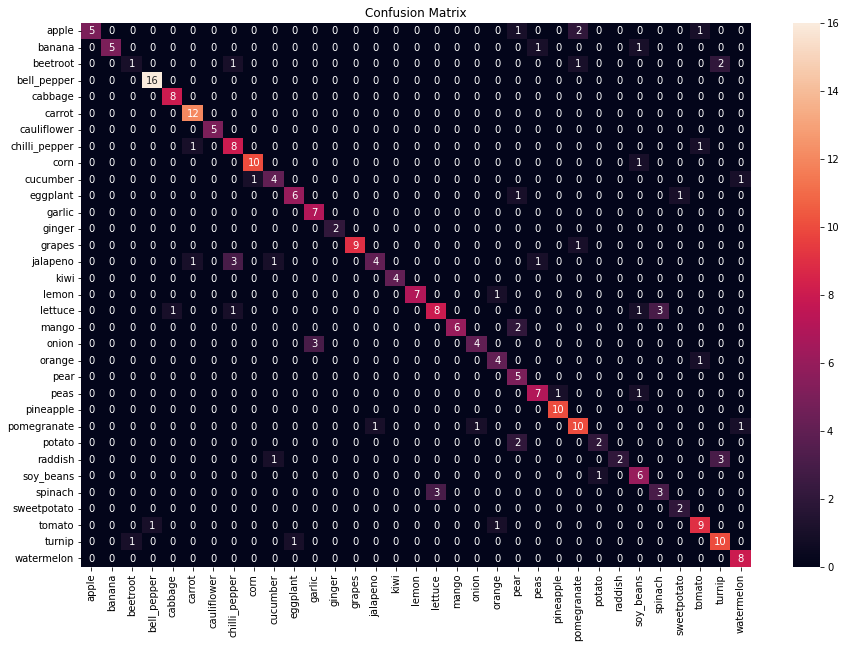



**********CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5*************************

{'precision': 0.830322746876868, 'recall': 0.8113207547169812, 'f1-score': 0.8094139926704914, 'support': 265}


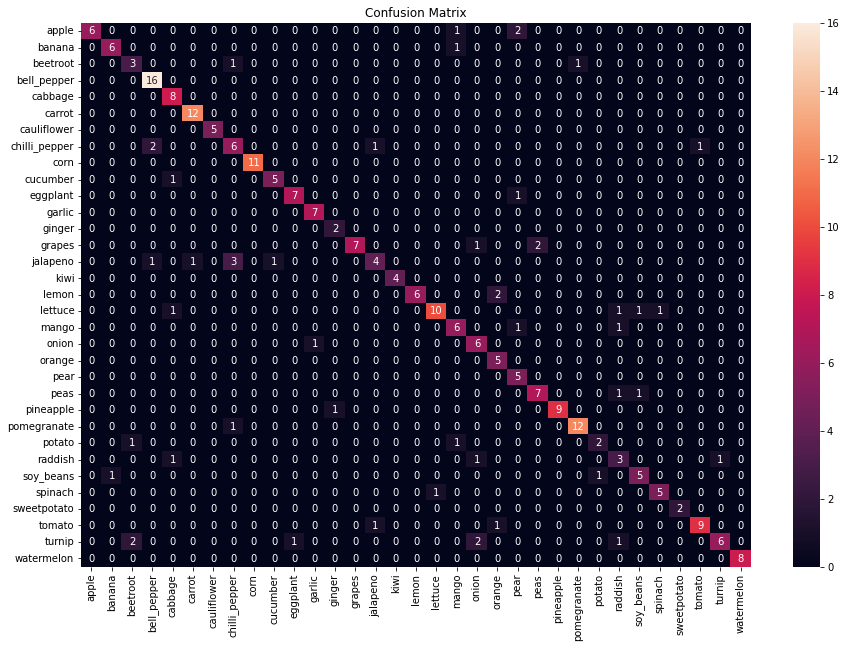



**********CategoricalClassifier_Model4_VGG16_Fine_tuning.h5*************************

{'precision': 0.8428180519689954, 'recall': 0.8150943396226416, 'f1-score': 0.814710945015971, 'support': 265}


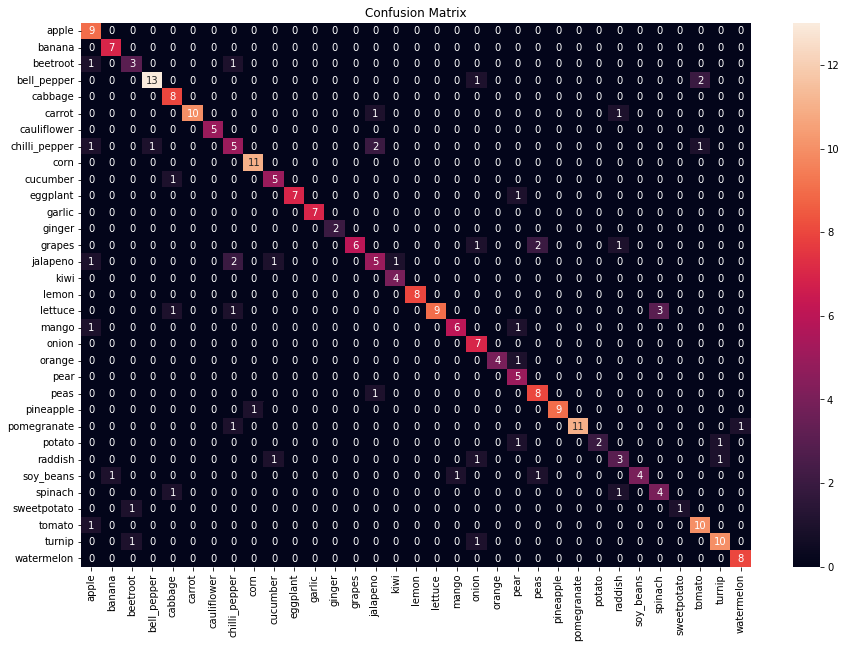

In [ ]:
dir = os.path.join(PATH_HOME, "models")

model_names_pretrained = ["CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5","CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5","CategoricalClassifier_Model4_VGG16_Fine_tuning.h5"]

for name_model in model_names_pretrained:
  model = keras.models.load_model(os.path.join(dir, name_model))

  prob = model.predict(X_test_pre_mul)
  pred = np.argmax(prob,axis=1)

  print("\n\n**********" + name_model + "*************************\n")
  print(classification_report(y_test_pre_mul, pred, target_names=labels_multilabel,output_dict = True)['weighted avg'])

  cf_matrix = confusion_matrix(y_test_pre_mul, pred, normalize=None)
  plt.figure(figsize = (15,10))
  sns.heatmap(cf_matrix, 
              annot=True, 
              xticklabels = labels_multilabel, 
              yticklabels = labels_multilabel,
              )

  plt.title('Confusion Matrix')
  plt.show()


### ResNet50



**********CategoricalClassifier_Model1_ResNet50_Fine_tuning.h5*************************

{'precision': 0.8516753452491521, 'recall': 0.8188679245283019, 'f1-score': 0.8119742998202707, 'support': 265}


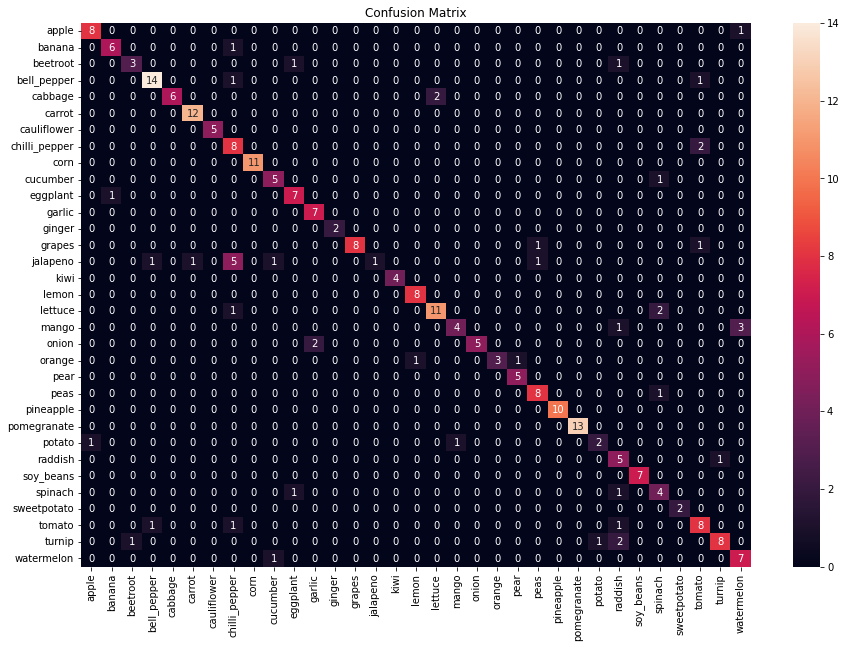



**********CategoricalClassifier_Model3a_ResNet50_Fine_tuning.h5*************************

{'precision': 0.8149537464631804, 'recall': 0.7962264150943397, 'f1-score': 0.7922278240538179, 'support': 265}


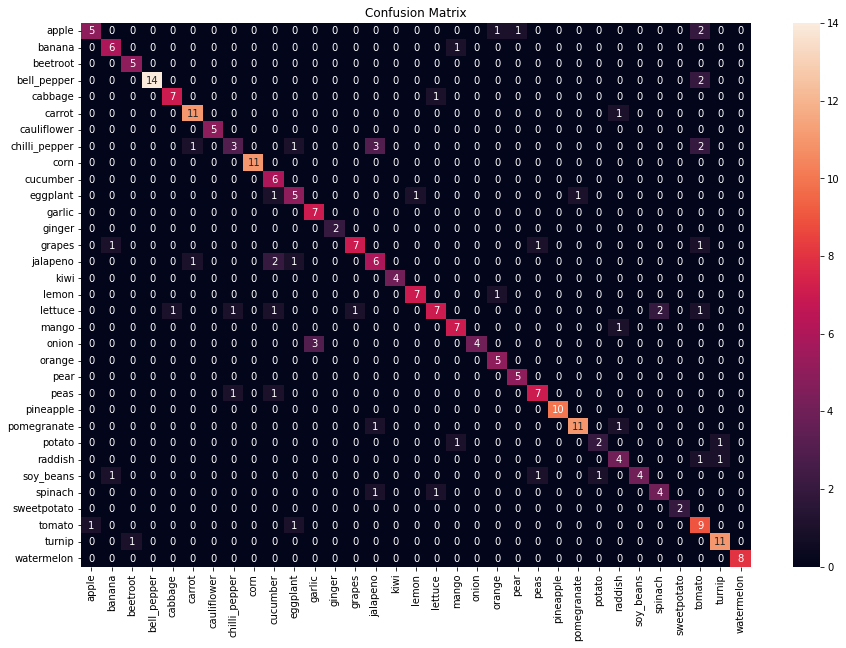



**********CategoricalClassifier_Model3b_ResNet50_Fine_tuning.h5*************************

{'precision': 0.8259804870182229, 'recall': 0.7811320754716982, 'f1-score': 0.7780623883627678, 'support': 265}


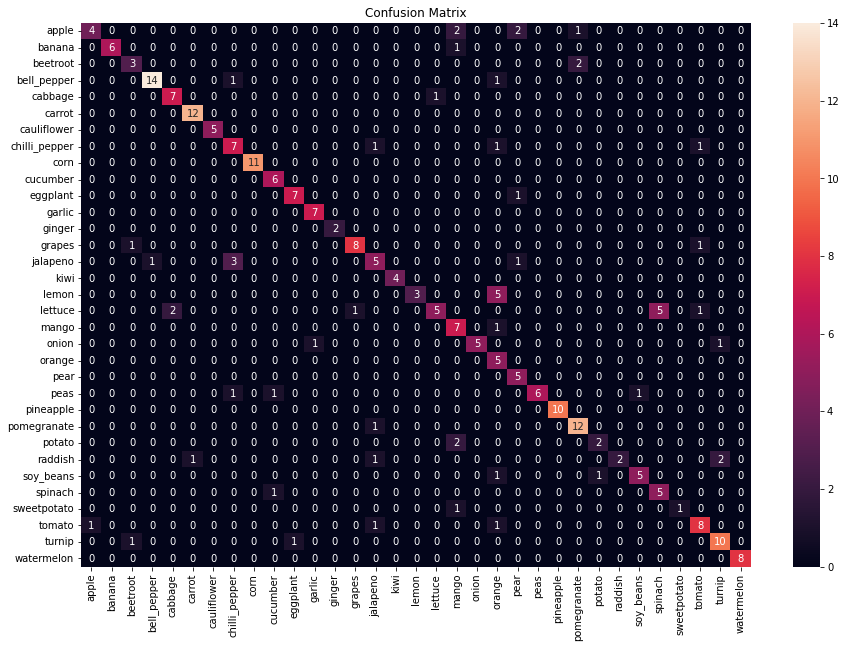

In [ ]:
dir = os.path.join(PATH_HOME, "models")

model_names_pretrained = ["CategoricalClassifier_Model1_ResNet50_Fine_tuning.h5","CategoricalClassifier_Model3a_ResNet50_Fine_tuning.h5","CategoricalClassifier_Model3b_ResNet50_Fine_tuning.h5"] #["CategoricalClassifier_Model3a_VGG16_Fine_tuning.h5","CategoricalClassifier_Model3b_VGG16_Fine_tuning.h5","CategoricalClassifier_Model4_VGG16_Fine_tuning.h5"]

for name_model in model_names_pretrained:
  model = keras.models.load_model(os.path.join(dir, name_model))

  prob = model.predict(X_test_pre_mul)
  pred = np.argmax(prob,axis=1)

  print("\n\n**********" + name_model + "*************************\n")
  print(classification_report(y_test_pre_mul, pred, target_names=labels_multilabel,output_dict = True)['weighted avg'])

  cf_matrix = confusion_matrix(y_test_pre_mul, pred, normalize=None)
  plt.figure(figsize = (15,10))
  sns.heatmap(cf_matrix, 
              annot=True, 
              xticklabels = labels_multilabel, 
              yticklabels = labels_multilabel,
              )

  plt.title('Confusion Matrix')
  plt.show()


### InceptionV3



**********CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5*************************

{'precision': 0.8209119496855347, 'recall': 0.8075471698113208, 'f1-score': 0.7987424715079852, 'support': 265}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


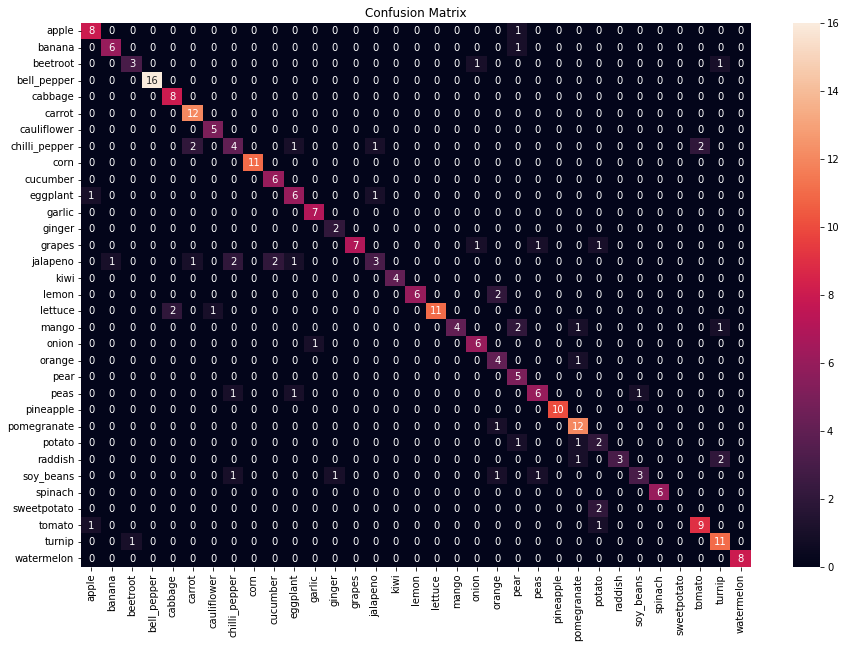



**********CategoricalClassifier_Model3a_InceptionV3_feature_extraction.h5*************************

{'precision': 0.7639405546456193, 'recall': 0.7735849056603774, 'f1-score': 0.7537841966030452, 'support': 265}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


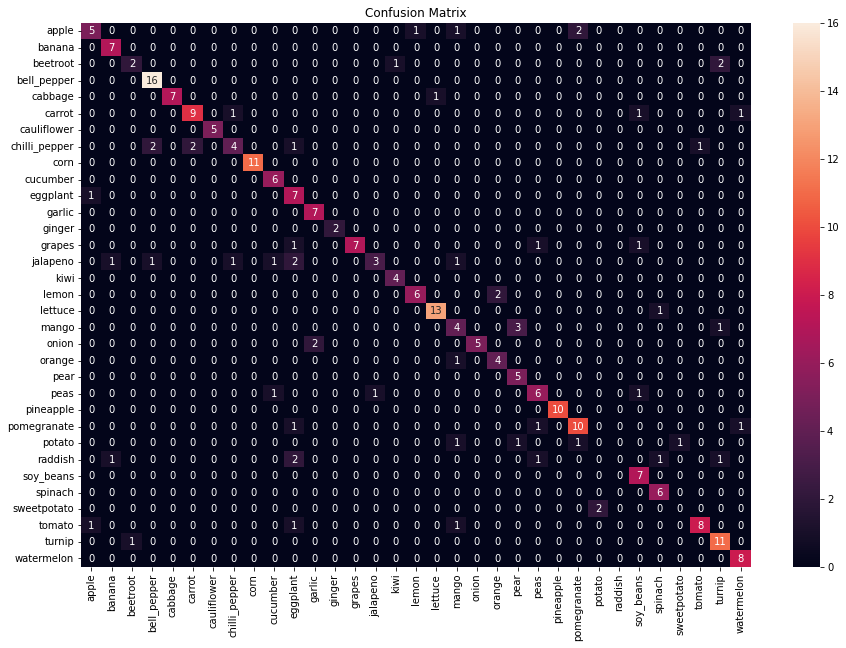



**********CategoricalClassifier_Model4_InceptionV3_Fine_tuning.h5*************************

{'precision': 0.8120447686485422, 'recall': 0.7811320754716982, 'f1-score': 0.7786736041681616, 'support': 265}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


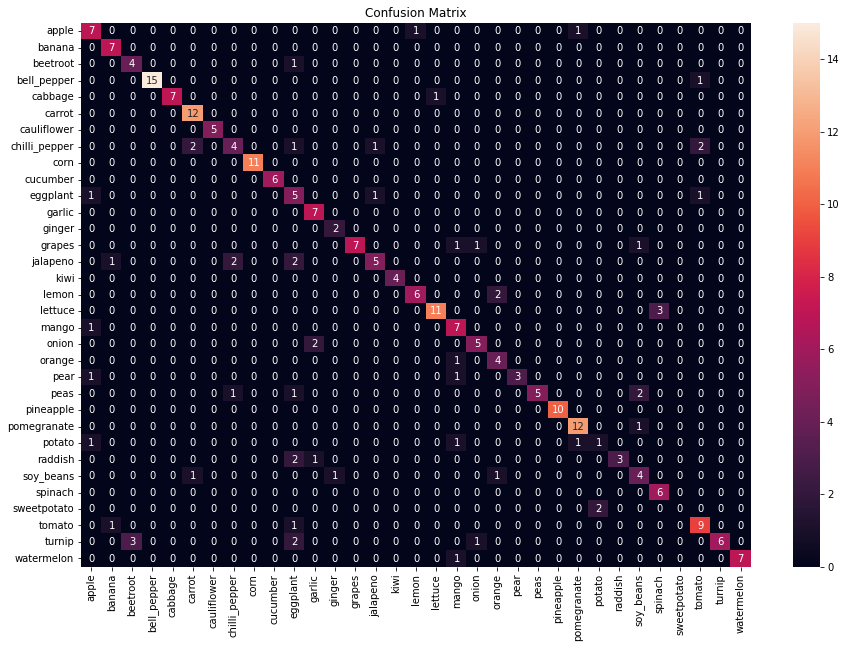

In [ ]:
dir = os.path.join(PATH_HOME, "models")

model_names_pretrained = ["CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5","CategoricalClassifier_Model3a_InceptionV3_feature_extraction.h5","CategoricalClassifier_Model4_InceptionV3_Fine_tuning.h5"]

for name_model in model_names_pretrained:
  model = keras.models.load_model(os.path.join(dir, name_model))

  prob = model.predict(X_test_pre_mul)
  pred = np.argmax(prob,axis=1)

  print("\n\n**********" + name_model + "*************************\n")
  print(classification_report(y_test_pre_mul, pred, target_names=labels_multilabel,output_dict = True)['weighted avg'])

  cf_matrix = confusion_matrix(y_test_pre_mul, pred, normalize=None)
  plt.figure(figsize = (15,10))
  sns.heatmap(cf_matrix, 
              annot=True, 
              xticklabels = labels_multilabel, 
              yticklabels = labels_multilabel,
              )

  plt.title('Confusion Matrix')
  plt.show()


## Ensemble

### Multiclass pretrained

In [ ]:
#facciamo la majority e la wheited di 3 modelli multi-lable pretrained

dir = os.path.join(PATH_HOME, "models")

model_names_pretrained = ["CategoricalClassifier_Model4_VGG16_Fine_tuning.h5","CategoricalClassifier_Model1_ResNet50_Fine_tuning.h5","CategoricalClassifier_Model2_InceptionV3_Fine_tuning.h5"] 

num_classes = 33

model_1 = keras.models.load_model(os.path.join(dir, model_names_pretrained[0]))
model_2 = keras.models.load_model(os.path.join(dir, model_names_pretrained[1]))
model_3 = keras.models.load_model(os.path.join(dir, model_names_pretrained[2]))

prob_1 = model_1.predict(X_test_pre_mul)
pred_1 = np.argmax(prob_1,axis=1)

prob_2 = model_2.predict(X_test_pre_mul)
pred_2 = np.argmax(prob_2,axis=1)

prob_3 = model_3.predict(X_test_pre_mul)
pred_3 = np.argmax(prob_3,axis=1)









In [ ]:
prob_predictions = [prob_1,prob_2,prob_3]
class_predictions = np.asarray([pred_1,pred_2,pred_3])





[28, 22, 9, 30, 23, 7, 17, 17, 5, 30, 6, 25, 19, 22, 13, 12, 19, 31, 23, 21, 7, 3, 17, 30, 0, 4, 7, 28, 18, 1, 10, 18, 8, 28, 30, 8, 5, 29, 10, 18, 31, 32, 0, 22, 24, 7, 31, 0, 16, 12, 24, 13, 0, 23, 28, 11, 5, 17, 28, 3, 11, 24, 16, 5, 22, 9, 6, 11, 25, 27, 30, 3, 18, 19, 31, 10, 3, 24, 1, 18, 21, 13, 15, 4, 20, 4, 0, 22, 3, 32, 14, 8, 21, 3, 6, 30, 17, 27, 15, 5, 24, 0, 19, 22, 0, 30, 26, 18, 4, 8, 30, 21, 8, 5, 24, 8, 24, 7, 10, 21, 0, 28, 30, 12, 13, 2, 16, 3, 23, 31, 6, 2, 30, 10, 15, 10, 24, 32, 13, 31, 7, 3, 18, 20, 8, 1, 0, 23, 10, 11, 30, 8, 15, 0, 23, 3, 23, 13, 31, 1, 4, 32, 14, 17, 7, 22, 24, 13, 3, 20, 1, 2, 32, 4, 9, 5, 14, 2, 5, 21, 10, 11, 4, 16, 9, 0, 32, 32, 19, 31, 0, 16, 16, 11, 5, 27, 30, 6, 20, 8, 7, 19, 27, 1, 26, 31, 23, 32, 11, 3, 17, 5, 7, 17, 19, 11, 4, 26, 3, 0, 31, 16, 9, 5, 13, 22, 1, 3, 10, 1, 4, 26, 31, 2, 5, 9, 7, 17, 5, 19, 31, 17, 21, 2, 23, 16, 22, 24, 3, 3, 24, 23, 28, 8, 7, 7, 8, 18, 9, 24, 24, 3, 1, 22, 17]


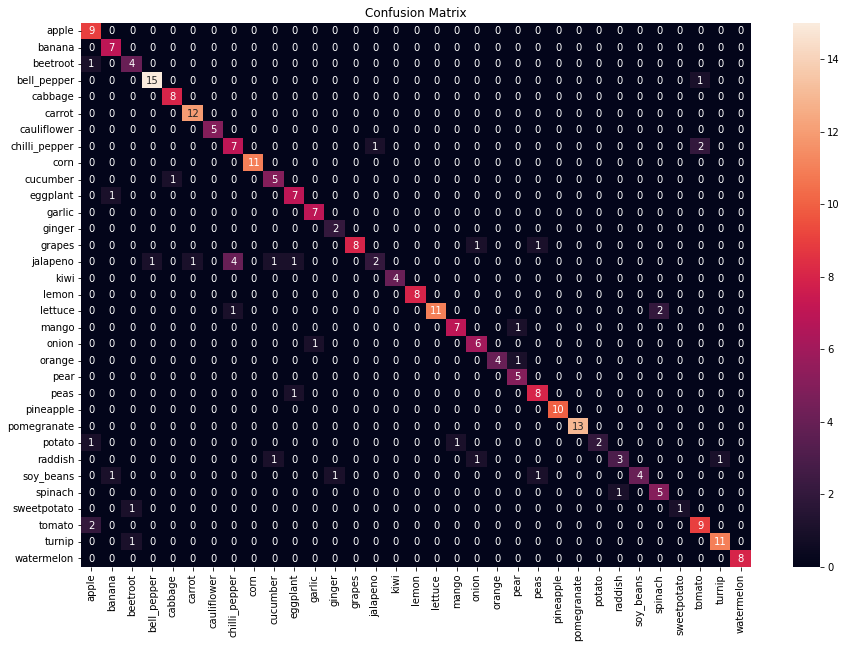

               precision    recall  f1-score   support

        apple       0.69      1.00      0.82         9
       banana       0.78      1.00      0.88         7
     beetroot       0.67      0.80      0.73         5
  bell_pepper       0.94      0.94      0.94        16
      cabbage       0.89      1.00      0.94         8
       carrot       0.92      1.00      0.96        12
  cauliflower       1.00      1.00      1.00         5
chilli_pepper       0.58      0.70      0.64        10
         corn       1.00      1.00      1.00        11
     cucumber       0.71      0.83      0.77         6
     eggplant       0.78      0.88      0.82         8
       garlic       0.88      1.00      0.93         7
       ginger       0.67      1.00      0.80         2
       grapes       1.00      0.80      0.89        10
     jalapeno       0.67      0.20      0.31        10
         kiwi       1.00      1.00      1.00         4
        lemon       1.00      1.00      1.00         8
      let

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


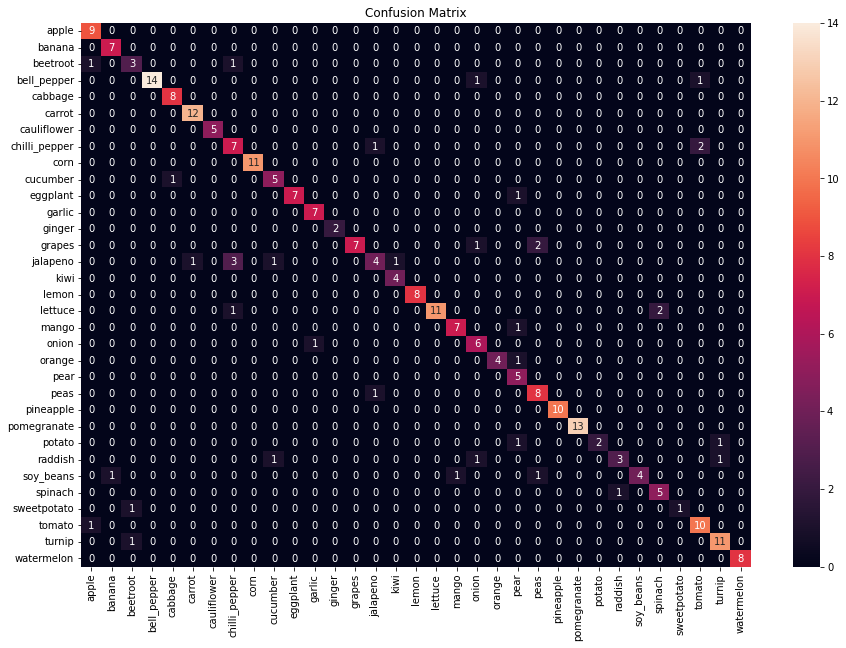

               precision    recall  f1-score   support

        apple       0.82      1.00      0.90         9
       banana       0.88      1.00      0.93         7
     beetroot       0.60      0.60      0.60         5
  bell_pepper       1.00      0.88      0.93        16
      cabbage       0.89      1.00      0.94         8
       carrot       0.92      1.00      0.96        12
  cauliflower       1.00      1.00      1.00         5
chilli_pepper       0.58      0.70      0.64        10
         corn       1.00      1.00      1.00        11
     cucumber       0.71      0.83      0.77         6
     eggplant       1.00      0.88      0.93         8
       garlic       0.88      1.00      0.93         7
       ginger       1.00      1.00      1.00         2
       grapes       1.00      0.70      0.82        10
     jalapeno       0.67      0.40      0.50        10
         kiwi       0.80      1.00      0.89         4
        lemon       1.00      1.00      1.00         8
      let

In [ ]:
maj_prediction = majority_prediction_classify(y_test_pre_mul,class_predictions,num_classes)
print(maj_prediction)

print_confusion_matrix(y_test_pre_mul,maj_prediction,labels_multilabel)

score_dict = classification_report(y_test_pre_mul, maj_prediction, target_names=labels_multilabel)
print(score_dict)











scores1 = classification_report(y_test_pre_mul, pred_1, target_names=labels_multilabel,output_dict = True)
weight1 = scores1['weighted avg']['f1-score'] 
scores2 = classification_report(y_test_pre_mul, pred_2, target_names=labels_multilabel,output_dict = True)
weight2 = scores2['weighted avg']['f1-score'] 
scores3 = classification_report(y_test_pre_mul, pred_3, target_names=labels_multilabel,output_dict = True)
weight3 = scores3['weighted avg']['f1-score'] 
weights = [weight1,weight2,weight3]


wei_prediction = weighted_prediction_classify(y_test_pre_mul,prob_predictions,weights,num_classes)
print_confusion_matrix(y_test_pre_mul,wei_prediction,labels_multilabel)

score_dict = classification_report(y_test_pre_mul, wei_prediction, target_names=labels_multilabel)
print(score_dict)


### Multilabel scratch

In [ ]:
dir = os.path.join(PATH_HOME, "models")



model_names_pretrained = ["model1_2aD5-scratch-multiclass.h5","model2aD2-scratch-multiclass.h5","model2aD5-scratch-multiclass.h5"] 

num_classes = 33

model_1 = keras.models.load_model(os.path.join(dir, model_names_pretrained[0]))
model_2 = keras.models.load_model(os.path.join(dir, model_names_pretrained[1]))
model_3 = keras.models.load_model(os.path.join(dir, model_names_pretrained[2]))

prob_1 = model_1.predict(X_test_scr_mul)
pred_1 = np.argmax(prob_1,axis=1)

prob_2 = model_2.predict(X_test_scr_mul)
pred_2 = np.argmax(prob_2,axis=1)

prob_3 = model_3.predict(X_test_scr_mul)
pred_3 = np.argmax(prob_3,axis=1)









In [ ]:
prob_predictions = [prob_1,prob_2,prob_3]
class_predictions = np.asarray([pred_1,pred_2,pred_3])





[28, 6, 4, 3, 23, 24, 28, 17, 3, 11, 6, 27, 2, 15, 0, 23, 14, 31, 5, 21, 5, 2, 2, 3, 3, 4, 0, 8, 3, 1, 3, 28, 19, 10, 7, 24, 24, 29, 9, 1, 31, 8, 3, 22, 3, 14, 20, 0, 7, 8, 29, 13, 31, 9, 17, 11, 31, 30, 28, 3, 19, 7, 8, 5, 8, 14, 24, 11, 0, 25, 32, 12, 29, 10, 31, 5, 3, 24, 1, 32, 3, 13, 15, 5, 5, 4, 3, 17, 14, 11, 9, 18, 8, 8, 6, 29, 6, 24, 28, 5, 22, 0, 0, 28, 8, 3, 24, 32, 15, 1, 21, 26, 8, 28, 24, 15, 0, 17, 10, 30, 5, 15, 30, 12, 13, 3, 8, 5, 31, 3, 7, 0, 30, 3, 2, 3, 24, 8, 13, 4, 30, 19, 10, 8, 28, 1, 0, 13, 15, 11, 3, 13, 11, 0, 28, 3, 23, 30, 31, 1, 17, 32, 22, 13, 14, 17, 24, 28, 3, 18, 1, 2, 27, 4, 14, 4, 9, 6, 8, 15, 10, 15, 17, 16, 9, 8, 15, 31, 3, 32, 31, 20, 16, 7, 2, 12, 5, 2, 4, 17, 3, 13, 13, 1, 9, 16, 23, 32, 11, 16, 15, 11, 31, 17, 32, 11, 22, 10, 31, 1, 31, 1, 9, 7, 11, 7, 14, 3, 23, 3, 4, 26, 11, 2, 5, 26, 5, 31, 5, 19, 19, 28, 21, 3, 23, 1, 28, 6, 3, 4, 2, 7, 1, 8, 25, 3, 28, 1, 16, 24, 23, 3, 17, 4, 20]


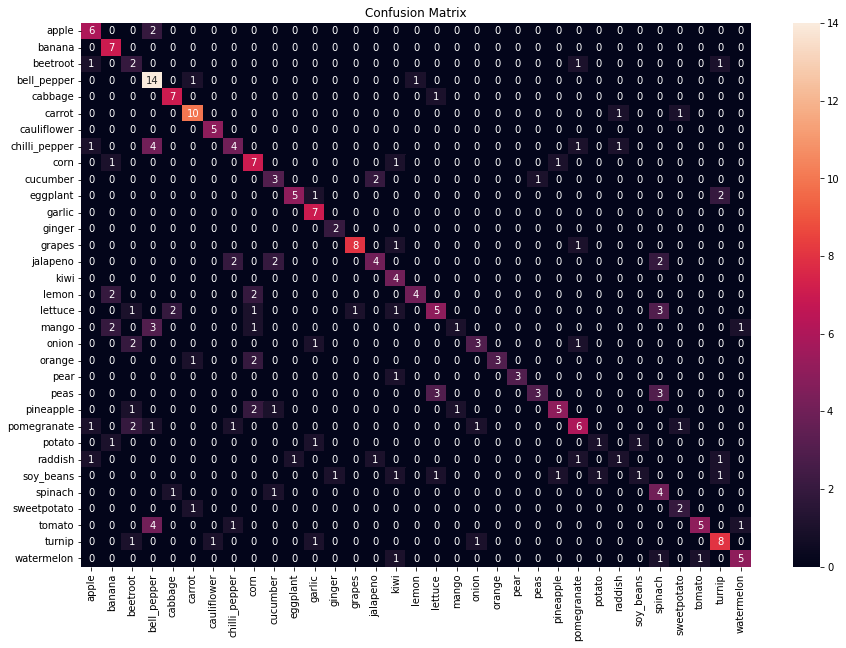

               precision    recall  f1-score   support

        apple       0.60      0.75      0.67         8
       banana       0.54      1.00      0.70         7
     beetroot       0.22      0.40      0.29         5
  bell_pepper       0.50      0.88      0.64        16
      cabbage       0.70      0.88      0.78         8
       carrot       0.77      0.83      0.80        12
  cauliflower       0.83      1.00      0.91         5
chilli_pepper       0.50      0.36      0.42        11
         corn       0.47      0.70      0.56        10
     cucumber       0.43      0.50      0.46         6
     eggplant       0.83      0.62      0.71         8
       garlic       0.64      1.00      0.78         7
       ginger       0.67      1.00      0.80         2
       grapes       0.89      0.80      0.84        10
     jalapeno       0.57      0.40      0.47        10
         kiwi       0.40      1.00      0.57         4
        lemon       0.80      0.50      0.62         8
      let

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


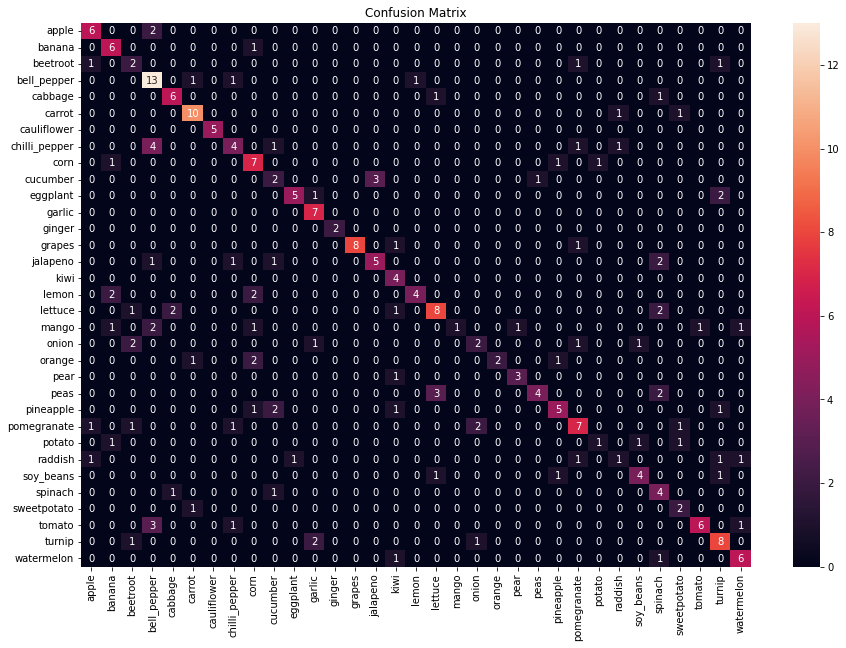

               precision    recall  f1-score   support

        apple       0.67      0.75      0.71         8
       banana       0.55      0.86      0.67         7
     beetroot       0.29      0.40      0.33         5
  bell_pepper       0.52      0.81      0.63        16
      cabbage       0.67      0.75      0.71         8
       carrot       0.77      0.83      0.80        12
  cauliflower       1.00      1.00      1.00         5
chilli_pepper       0.50      0.36      0.42        11
         corn       0.50      0.70      0.58        10
     cucumber       0.29      0.33      0.31         6
     eggplant       0.83      0.62      0.71         8
       garlic       0.64      1.00      0.78         7
       ginger       1.00      1.00      1.00         2
       grapes       1.00      0.80      0.89        10
     jalapeno       0.62      0.50      0.56        10
         kiwi       0.44      1.00      0.62         4
        lemon       0.80      0.50      0.62         8
      let

In [ ]:
#new
maj_prediction = majority_prediction_classify(y_test_scr_mul,class_predictions,num_classes)
print(maj_prediction)

print_confusion_matrix(y_test_scr_mul,maj_prediction,labels_multilabel)

score_dict = classification_report(y_test_scr_mul, maj_prediction, target_names=labels_multilabel)
print(score_dict)



scores1 = classification_report(y_test_scr_mul, pred_1, target_names=labels_multilabel,output_dict = True)
weight1 = scores1['weighted avg']['f1-score'] 
scores2 = classification_report(y_test_scr_mul, pred_2, target_names=labels_multilabel,output_dict = True)
weight2 = scores2['weighted avg']['f1-score'] 
scores3 = classification_report(y_test_scr_mul, pred_3, target_names=labels_multilabel,output_dict = True)
weight3 = scores3['weighted avg']['f1-score'] 
weights = [weight1,weight2,weight3]


wei_prediction = weighted_prediction_classify(y_test_scr_mul,prob_predictions,weights,num_classes)
print_confusion_matrix(y_test_scr_mul,wei_prediction,labels_multilabel)

score_dict = classification_report(y_test_scr_mul, wei_prediction, target_names=labels_multilabel)
print(score_dict)


### Binary Pretrained and Scratch

In [ ]:
dir = os.path.join(PATH_HOME, "models")
model_pretrained_binary1 = keras.models.load_model(os.path.join(dir, "BinaryClassifier_Model3a_ResNet50_Fine_tuning.h5"))
model_pretrained_binary2 = keras.models.load_model(os.path.join(dir, "BinaryClassifier_Model3a_VGG16_Fine_tuning.h5"))
model_pretrained_binary3 = keras.models.load_model(os.path.join(dir, "BinaryClassifier_Model4_InceptionV3_Fine_tuning.h5"))

In [ ]:
# binary
num_classes = 2

#scratch
prob1 = model_pretrained_binary1.predict(test_set)
prob2 = model_pretrained_binary2.predict(test_set)
prob3 = model_pretrained_binary3.predict(test_set)
prob_predictions = [prob1,prob2,prob3]

pred1 = prob1.copy()
pred2 = prob2.copy()
pred3 = prob3.copy()

pred1[pred1 <= 0.5] = 0
pred1[pred1 > 0.5] = 1
pred1 = pred1[:,0]

pred2[pred2 <= 0.5] = 0
pred2[pred2 > 0.5] = 1
pred2 = pred2[:,0]

pred3[pred3 <= 0.5] = 0
pred3[pred3 > 0.5] = 1
pred3 = pred3[:,0]



[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 

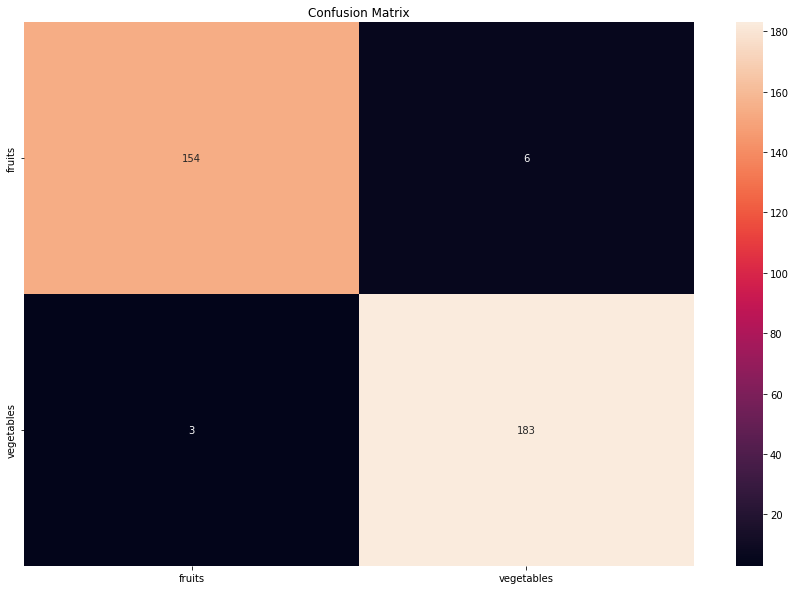

              precision    recall  f1-score   support

      fruits       0.98      0.96      0.97       160
  vegetables       0.97      0.98      0.98       186

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



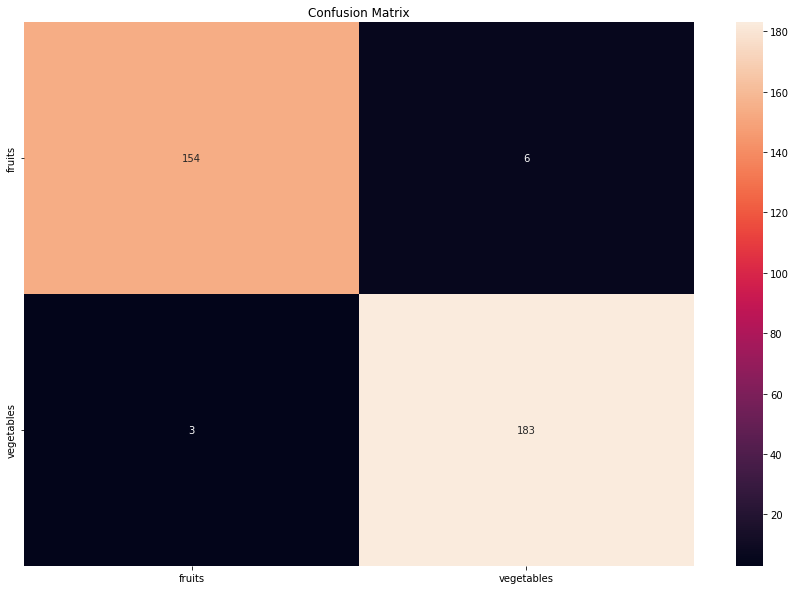

              precision    recall  f1-score   support

      fruits       0.98      0.96      0.97       160
  vegetables       0.97      0.98      0.98       186

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



In [ ]:
class_predictions = np.asarray([pred1,pred2,pred3],dtype='int')




#etichette = get_labels_alphabetic
scores1 = classification_report(test_labels, pred1, target_names=labels_set,output_dict = True)
weight1 = scores1['accuracy'] 
scores2 = classification_report(test_labels, pred2, target_names=labels_set,output_dict = True)
weight2 = scores2['accuracy'] 
scores3 = classification_report(test_labels, pred3, target_names=labels_set,output_dict = True)
weight3 = scores3['accuracy'] 
weights = [weight1,weight2,weight3]


maj_prediction = majority_prediction_classify(test_labels,class_predictions,num_classes)
print(maj_prediction)

print_confusion_matrix(test_labels,maj_prediction,labels_set)

score_dict = classification_report(test_labels, maj_prediction, target_names=labels_set)
print(score_dict)



prova = []

for prediction in prob_predictions:
  vettore = []

  for j in range(len(prediction)):
    elem1 = prediction[j] #elem1 diventa automaticamente un array a una dimensione...

    elem2 = 1 - prediction[j]

    vettore.append([elem2,elem1])
  prova.append(vettore)

wei_prediction = weighted_prediction_classify(test_labels,prova,weights,num_classes)
wei_prediction = wei_prediction[:,0]
print_confusion_matrix(test_labels,wei_prediction,labels_set)


score_dict = classification_report(test_labels, wei_prediction, target_names=labels_set)
print(score_dict)

#stampa scores

In [ ]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

dataset_preprocessed = image_dataset_from_directory(
    os.path.join(PATH_DATASET_BINARY, ''),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 3469 files belonging to 2 classes.


In [ ]:
training_preprocessed =image_dataset_from_directory(
    PATH_DATASET_BINARY,
    validation_split=0.1,
    subset= "training",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    seed = 123,
    batch_size=BATCH_SIZE)


Found 3469 files belonging to 2 classes.
Using 3123 files for training.


In [ ]:
test_preprocessed =image_dataset_from_directory(
    PATH_DATASET_BINARY,
    validation_split=0.1,
    subset= "validation",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    seed = 123,
    batch_size=BATCH_SIZE)


Found 3469 files belonging to 2 classes.
Using 346 files for validation.


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
#dataset = image_dataset_from_directory(directory)
rescale = Rescaling(scale=1.0/255)
rescaled_dataset = test_preprocessed.map(lambda image,label:(rescale(image),label))

In [ ]:
test_set, test_labels = conversion_batch_to_narray(rescaled_dataset)

(32, 180, 180, 3)
(32, 180, 180, 3)
1
(32, 180, 180, 3)
(64, 180, 180, 3)
2
(32, 180, 180, 3)
(96, 180, 180, 3)
3
(32, 180, 180, 3)
(128, 180, 180, 3)
4
(32, 180, 180, 3)
(160, 180, 180, 3)
5
(32, 180, 180, 3)
(192, 180, 180, 3)
6
(32, 180, 180, 3)
(224, 180, 180, 3)
7
(32, 180, 180, 3)
(256, 180, 180, 3)
8
(32, 180, 180, 3)
(288, 180, 180, 3)
9
(32, 180, 180, 3)
(320, 180, 180, 3)
10
(26, 180, 180, 3)
(346, 180, 180, 3)
11


In [ ]:
dir = os.path.join(PATH_HOME, "models")
model_pretrained_binary1 = keras.models.load_model(os.path.join(dir, "model5-scratch-binaryclass.h5"))
model_pretrained_binary2 = keras.models.load_model(os.path.join(dir, "model6b-scratch-binaryclass.h5"))
model_pretrained_binary3 = keras.models.load_model(os.path.join(dir, "model7-scratch-binaryclass.h5"))



In [ ]:
labels_set = sorted(os.listdir(PATH_DATASET_BINARY))
print(labels_set)

['fruits', 'vegetables']


In [ ]:
# binary
num_classes = 2

#scratch
prob1 = model_pretrained_binary1.predict(test_set)
prob2 = model_pretrained_binary2.predict(test_set)
prob3 = model_pretrained_binary3.predict(test_set)
prob_predictions = [prob1,prob2,prob3]

pred1 = prob1.copy()
pred2 = prob2.copy()
pred3 = prob3.copy()

pred1[pred1 <= 0.5] = 0
pred1[pred1 > 0.5] = 1
pred1 = pred1[:,0]

pred2[pred2 <= 0.5] = 0
pred2[pred2 > 0.5] = 1
pred2 = pred2[:,0]

pred3[pred3 <= 0.5] = 0
pred3[pred3 > 0.5] = 1
pred3 = pred3[:,0]



[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

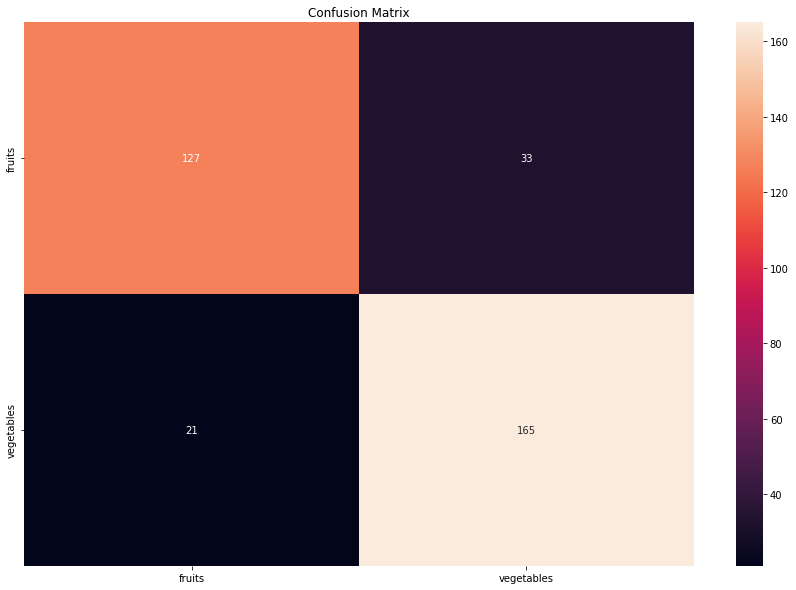

              precision    recall  f1-score   support

      fruits       0.86      0.79      0.82       160
  vegetables       0.83      0.89      0.86       186

    accuracy                           0.84       346
   macro avg       0.85      0.84      0.84       346
weighted avg       0.84      0.84      0.84       346



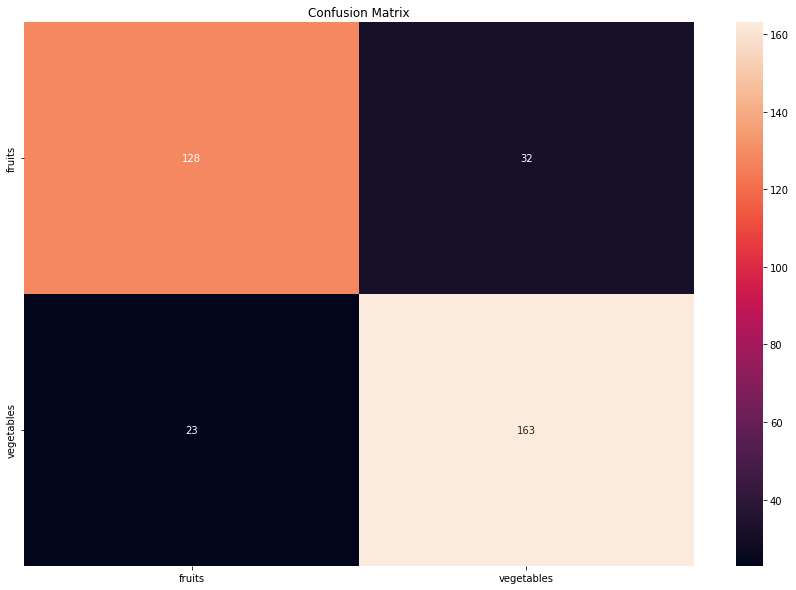

              precision    recall  f1-score   support

      fruits       0.85      0.80      0.82       160
  vegetables       0.84      0.88      0.86       186

    accuracy                           0.84       346
   macro avg       0.84      0.84      0.84       346
weighted avg       0.84      0.84      0.84       346



In [ ]:
class_predictions = np.asarray([pred1,pred2,pred3],dtype='int')




#etichette = get_labels_alphabetic
scores1 = classification_report(test_labels, pred1, target_names=labels_set,output_dict = True)
weight1 = scores1['accuracy'] 
scores2 = classification_report(test_labels, pred2, target_names=labels_set,output_dict = True)
weight2 = scores2['accuracy'] 
scores3 = classification_report(test_labels, pred3, target_names=labels_set,output_dict = True)
weight3 = scores3['accuracy'] 
weights = [weight1,weight2,weight3]


maj_prediction = majority_prediction_classify(test_labels,class_predictions,num_classes)
print(maj_prediction)

print_confusion_matrix(test_labels,maj_prediction,labels_set)

score_dict = classification_report(test_labels, maj_prediction, target_names=labels_set)
print(score_dict)



prova = []

for prediction in prob_predictions:
  vettore = []

  for j in range(len(prediction)):
    elem1 = prediction[j] #elem1 diventa automaticamente un array a una dimensione...

    elem2 = 1 - prediction[j]

    vettore.append([elem2,elem1])
  prova.append(vettore)

wei_prediction = weighted_prediction_classify(test_labels,prova,weights,num_classes)
wei_prediction = wei_prediction[:,0]
print_confusion_matrix(test_labels,wei_prediction,labels_set)


score_dict = classification_report(test_labels, wei_prediction, target_names=labels_set)
print(score_dict)

#stampa scores